## 预处理阶段

In [1]:
# 导入包
import sys
import time
import argparse
import os
import numpy as np
import math

import torchvision.transforms as transforms
from torchvision.utils import save_image

from torch.utils.data import  DataLoader
from torchvision import  datasets
from torch.autograd import Variable

import torch.nn as nn
import torch.nn.functional as F
import torch

/home/cxmd/mambaforge/envs/pytorch/lib/python3.11/site-packages/torchvision/io/image.py:13: UserWarning: Failed to load image Python extension: '/home/cxmd/mambaforge/envs/pytorch/lib/python3.11/site-packages/torchvision/image.so: undefined symbol: _ZN3c106detail23torchInternalAssertFailEPKcS2_jS2_RKSs'If you don't plan on using image functionality from `torchvision.io`, you can ignore this warning. Otherwise, there might be something wrong with your environment. Did you have `libjpeg` or `libpng` installed before building `torchvision` from source?
  warn(


In [2]:
# 计划使用GPU运行
# 检查是否有可用的GPU
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
device

device(type='cuda')

In [3]:
# 超参数设置
n_epochs = 200      # 训练集总训练轮次
batch_size = 64
lr = 0.0002           # 学习率
b1 = 0.5 
b2 = 0.999
latent_dim = 100    # 隐变量维度
img_size = 28       # 每维度图片大小
channels = 1        # 图片通道数
sample_interval = 400    # 生成图片间隔
sample_dir = 'demo2'    # 生成图片保存路径

img_shape = (channels, img_size, img_size)

In [4]:
# 建立文件夹用于存放训练过程的图像，如果文件夹不存在，就创建一个
if not os.path.exists(sample_dir):
    os.makedirs(sample_dir)

## MNIST 数据集

In [5]:
# transform配置
transform = transforms.Compose(
    [
        transforms.ToTensor(),
        transforms.Normalize(
            mean=0.5,
            std=0.5,
        ),
    ]
)

In [6]:
# 加载mnist数据，同时将数据按照transform的配置预处理
# 判断是什么操作系统，以设置相应的数据集路径
if sys.platform.startswith('win'):
    datasetpath = 'D:\\nndatasets'
else:
    datasetpath = '/home/cxmd/文档/data_for_AI_train/mnist_data'

mnist = datasets.MNIST(
    root=datasetpath,
    train=True,
    transform=transform,
    download=True,
)

In [7]:
# 数据集加载器：GAN为无监督机器学习
# 参数dataset是要加载的数据集，这里是预处理后的mnist数据集
# 参数batch_size是每个批次的样本数量
# 参数shuffle为True表示在每个训练周期开始时，对数据进行重新洗牌
data_loader = DataLoader(
    dataset = mnist,
    batch_size=batch_size,
    shuffle=True,
)
data_loader

## 生成器共和判别器的创建

In [8]:
# 创建生成器
class Generator(nn.Module):
    def __init__(self):
        super(Generator, self).__init__()     # super用来调用Generator父类的函数
    
        def block(in_feat, out_feat, normalize=True):
            # 创建一个神经网络的基本块，包含一个线性层，可能的一个批量归一化层，以及一个LeakyReLU激活函数
            # in_feat: 输入特征的数量
            # out_feat: 输出特征的数量
            # normalize: 是否添加批量归一化层

            # 创建一个线性层
            layers = [nn.Linear(in_feat, out_feat)]
            
            # 如果normalize为True，添加一个批量归一化层
            if normalize:
                layers.append(nn.BatchNorm1d(out_feat, 0.8))
            
            # 添加一个LeakyReLU激活函数
            layers.append(nn.LeakyReLU(0.2, inplace=True))
            
            # 返回这个基本块的层列表
            return layers
        
        self.model = nn.Sequential(
            *block(latent_dim, 128, normalize=False),     # *号表示解包操作，将列表中的层在Sequential中依次排列出来
            *block(128, 256),
            *block(256, 512),
            *block(512, 1024),
            nn.Linear(1024, int(np.prod(img_shape))),
            nn.Tanh()
        )
    
    def forward(self, z):
        # 将输入z通过生成器模型进行前向传播，得到输出img
        img = self.model(z)
        
        # 将img的形状从(batch_size, channels*img_size*img_size)变为(batch_size, channels, img_size, img_size)
        # 这是因为生成的图像数据需要是一个四维的张量，其形状为(batch_size, channels, img_size, img_size)
        img = img.view(img.size(0), *img_shape)
        
        # 返回生成的图像数据
        return img

In [9]:
# 创建判别器
class Discriminator(nn.Module):
    def __init__(self):
        super(Discriminator, self).__init__()
        
        self.model = nn.Sequential(
            nn.Linear(int(np.prod(img_shape)), 512),
            nn.LeakyReLU(0.2, inplace=True),
            nn.Linear(512, 256),
            nn.LeakyReLU(0.2, inplace=True),
            nn.Linear(256, 1),
            nn.Sigmoid(),
        )
    
    def forward(self, img):
        # 将输入的图像数据img的形状从(batch_size, channels, img_size, img_size)变为(batch_size, channels*img_size*img_size)
        # 这是因为判别器的输入需要是一个二维的张量，其形状为(batch_size, channels*img_size*img_size)
        img_flat = img.view(img.size(0), -1)
        
        # 将输入的图像数据img_flat通过判别器模型进行前向传播，得到输出validity
        # validity是一个二维的张量，其形状为(batch_size, 1)，表示判别器对每个图像数据是真实的还是假的的判断
        validity = self.model(img_flat)
        
        # 返回判别器的判断结果
        return validity

In [10]:
# 初始化生成器和判别器
generator = Generator().to(device)
discriminator = Discriminator().to(device)

In [11]:
# 设置损失函数和优化器
adversarial_loss = nn.BCELoss() # 二值交叉熵 Binary cross entropy loss
optimizer_G = torch.optim.Adam(generator.parameters(), lr=lr, betas=(b1, b2))
optimizer_D = torch.optim.Adam(discriminator.parameters(), lr=lr, betas=(b1, b2))

## 训练

In [12]:
Tensor = torch.cuda.FloatTensor if torch.cuda.is_available() else torch.FloatTensor   # 在什么设备运行浮点运算

# 记录开始训练的时间
start_time = time.time()

for epoch in range(n_epochs):
    for i, (imgs, _) in enumerate(data_loader):
        
        # 创建真实图像和生成图像的标签
        # valid = Variable(Tensor(imgs.size(0), 1).fill_(1.0), requires_grad=False).to(device)
        # fake = Variable(Tensor(imgs.size(0), 1).fill_(0.0), requires_grad=False).to(device)
        valid = torch.ones([imgs.size(0), 1]).to(device)
        fake = torch.zeros([imgs.size(0), 1]).to(device)
        
        # 真实输入训练集
        real_imgs = Variable(imgs.type(Tensor)).to(device)
        
        
        # -----------------
        #  训练生成器
        # -----------------
        
        optimizer_G.zero_grad()
        
        # 生成正态分布噪声以作为生成器的输入
        z = torch.tensor(np.random.normal(0, 1, (imgs.shape[0], latent_dim)), dtype=torch.float32).to(device)
        
        # 生成器生成的图像
        gen_imgs = generator(z)
        
        # 生成器损失函数来衡量生成器欺骗判别器的能力
        g_loss = adversarial_loss(discriminator(gen_imgs), valid)
        
        g_loss.backward()
        optimizer_G.step()
        
        # ---------------------
        #  训练判别器
        # ---------------------
        
        optimizer_D.zero_grad()
        
        # 判别器损失函数来衡量分辨出真实图片和生成器生成图片的能力
        
        real_loss = adversarial_loss(discriminator(real_imgs), valid)
        fake_loss = adversarial_loss(discriminator(gen_imgs.detach()), fake)
        d_loss = (real_loss + fake_loss) / 2
        
        real_score = discriminator(real_imgs)
        fake_score = discriminator(gen_imgs.detach())
        
        d_loss.backward()
        optimizer_D.step()
        
        if (i + 1) % 100 == 0:      # 每一百批次输入一次训练程度
            # 计算过去的时间
            elapsed_time = time.time() - start_time
            print('Elapsed time: {:.4f} seconds, Epoch [{}/{}], Step [{}/{}], d_loss: {:.4f}, g_loss: {:.4f}, D(x): {:.2f}, D(G(z)): {:.2f}'.format(elapsed_time, epoch + 1, n_epochs, i + 1, len(data_loader), d_loss.item(), g_loss.item(), real_score.mean().item(), fake_score.mean().item()))
    
    # 在第一轮保存训练数据图像
    if epoch == 0:
        imgs = imgs.reshape(imgs.size(0), 1, 28, 28)
        imgs = ((imgs + 1) / 2).clamp(0, 1)
        save_image(imgs, os.path.join(sample_dir, 'real_images.png'))
    
    # 每一论保存生成的样本(集fake_images)
    gen_imgs = gen_imgs.reshape(gen_imgs.size(0), 1, 28, 28)
    gen_imgs = ((gen_imgs + 1) / 2).clamp(0, 1)
    save_image(gen_imgs, os.path.join(sample_dir, 'fake_images-{}.png'.format(epoch + 1)))


# windows11 1080 3287s

Elapsed time: 1.2989 seconds, Epoch [1/200], Step [100/938], d_loss: 0.4088, g_loss: 0.9359, D(x): 0.74, D(G(z)): 0.39
Elapsed time: 2.4341 seconds, Epoch [1/200], Step [200/938], d_loss: 0.6682, g_loss: 0.5531, D(x): 0.63, D(G(z)): 0.58
Elapsed time: 3.4902 seconds, Epoch [1/200], Step [300/938], d_loss: 0.4056, g_loss: 0.9757, D(x): 0.73, D(G(z)): 0.38
Elapsed time: 4.5361 seconds, Epoch [1/200], Step [400/938], d_loss: 0.7366, g_loss: 0.3178, D(x): 0.85, D(G(z)): 0.73
Elapsed time: 5.5974 seconds, Epoch [1/200], Step [500/938], d_loss: 0.4378, g_loss: 0.9906, D(x): 0.68, D(G(z)): 0.37
Elapsed time: 6.6376 seconds, Epoch [1/200], Step [600/938], d_loss: 0.3393, g_loss: 0.9355, D(x): 0.85, D(G(z)): 0.40
Elapsed time: 7.6684 seconds, Epoch [1/200], Step [700/938], d_loss: 0.4889, g_loss: 0.7725, D(x): 0.73, D(G(z)): 0.47
Elapsed time: 8.7117 seconds, Epoch [1/200], Step [800/938], d_loss: 0.5326, g_loss: 0.4869, D(x): 0.91, D(G(z)): 0.62
Elapsed time: 9.7640 seconds, Epoch [1/200], Ste

## 结果展示

In [13]:
# 导入包
import matplotlib.pyplot as plt
import scienceplots
plt.style.use(['science', 'ieee'])
import matplotlib.image as mpimg     # 用于读取图片
import numpy as np

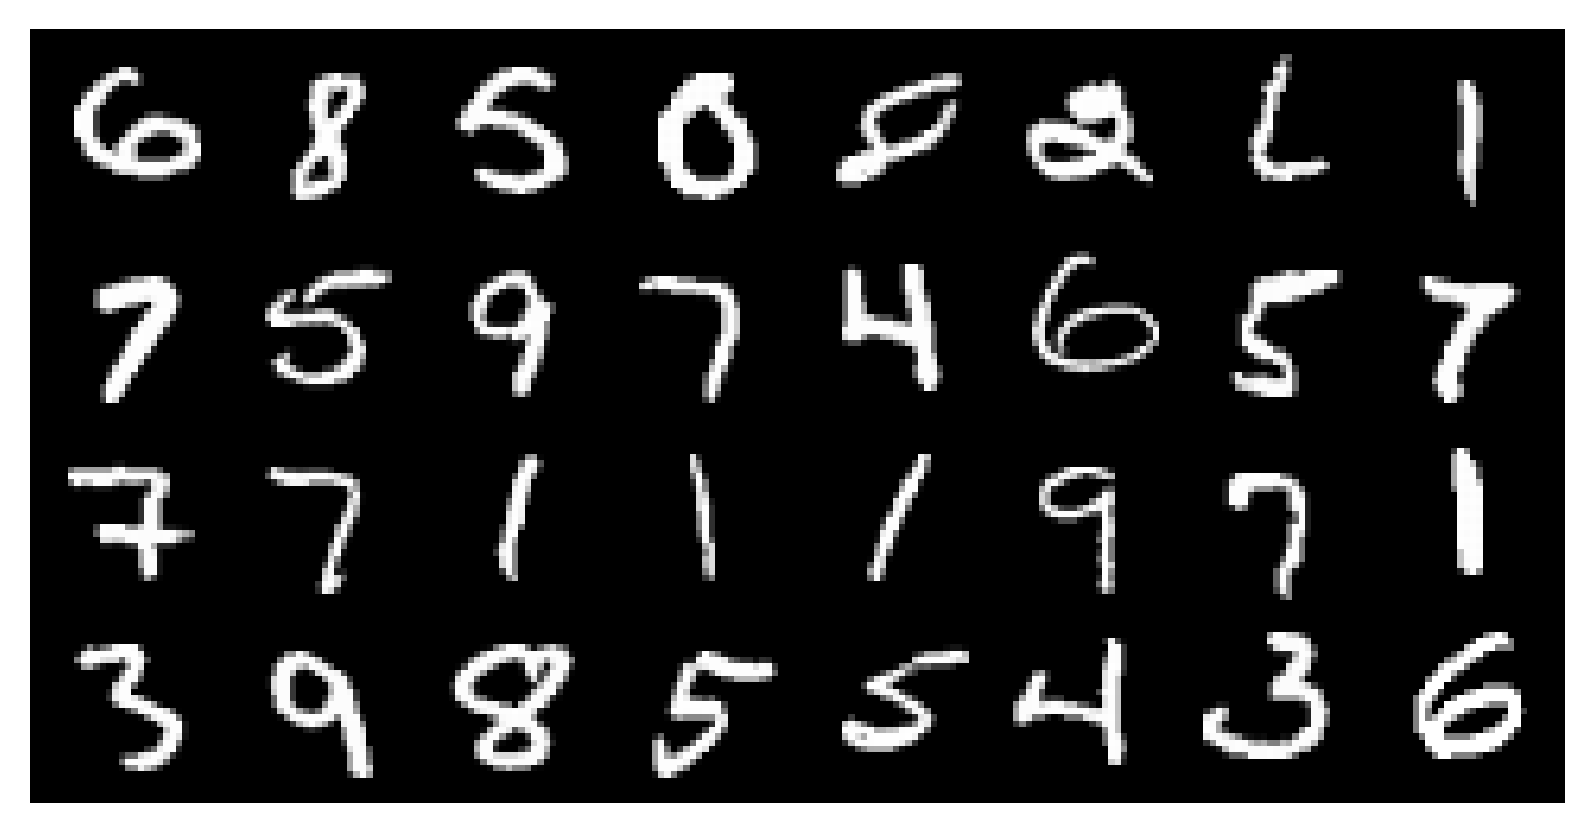

In [14]:
real_path = './demo2/real_images.png'
realImage = mpimg.imread(real_path)
plt.imshow(realImage)
plt.axis('off')   # 不显示坐标轴
plt.show()

#### fake image进化过程

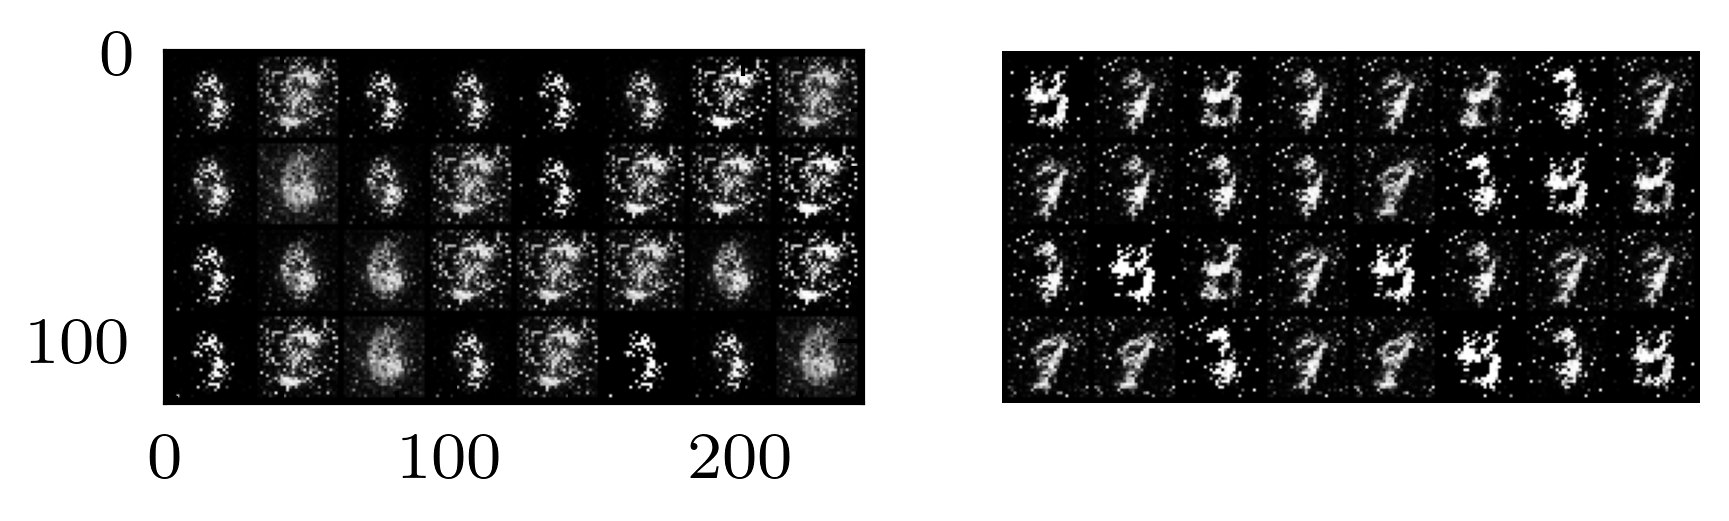

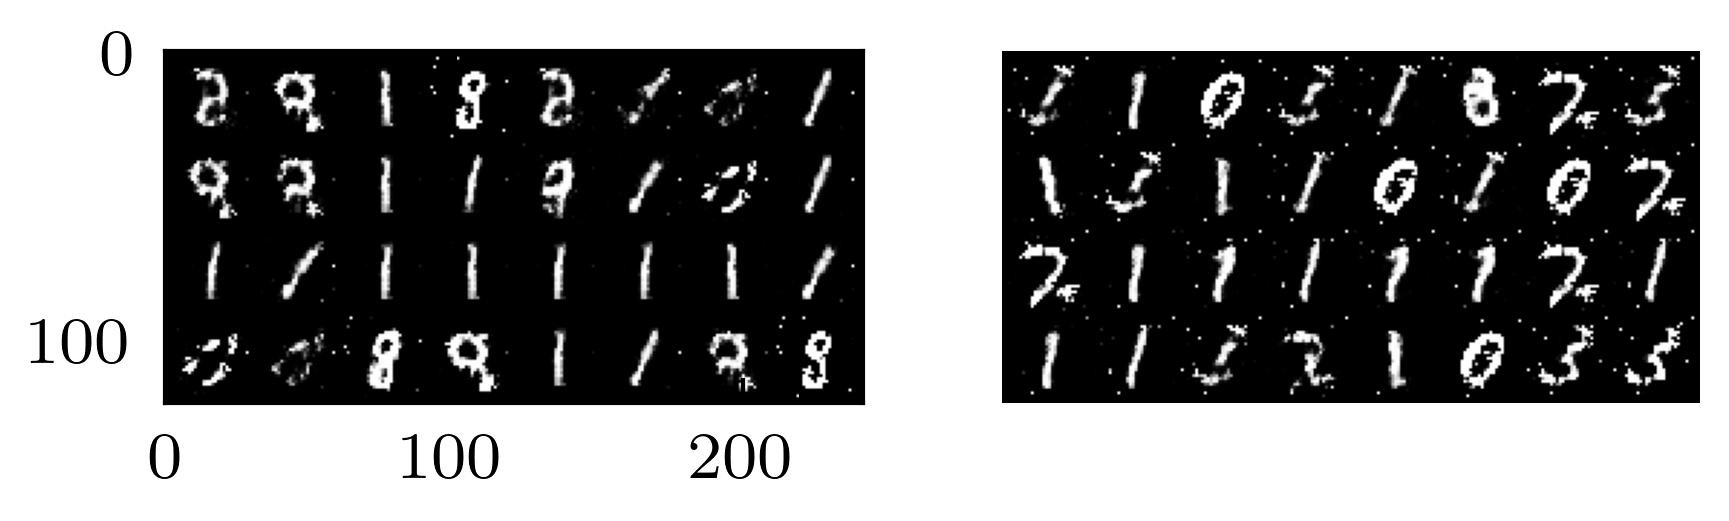

In [15]:
# 起始阶段
fakePath1 = './demo2/fake_images-1.png'
fakeImg1 = mpimg.imread(fakePath1)

fakePath5 = './demo2/fake_images-5.png'
fakeImg5 = mpimg.imread(fakePath5)


fig, ax = plt.subplots(1, 2)
ax[0].imshow(fakeImg1)
ax[1].imshow(fakeImg5)
plt.axis('off')
plt.show()


fakePath195 = './demo2/fake_images-195.png'
fakeImg195 = mpimg.imread(fakePath195)

fakePath200 = './demo2/fake_images-200.png'
fakeImg200 = mpimg.imread(fakePath200)

fig, ax = plt.subplots(1, 2)
ax[0].imshow(fakeImg195)
ax[1].imshow(fakeImg200)
plt.axis('off')
plt.show()
